In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from IPython.display import display, HTML, display_html

In [2]:
# import master dataframe
master_df = pd.read_csv('data/master_df.csv')

# drop rows with NaN
master_df.dropna(how='any',axis=0, inplace=True) 

# drop index
master_df.drop(master_df.columns[0], axis=1, inplace=True)

# one hot encode days of the week, month
master_df = pd.get_dummies(master_df, columns=['DAY_OF_WEEK','MONTH'])

In [3]:
master_df.head()

,Lat,Long,HOUR,TAVG,PRCP,SNOW,closest_property_value,neighborhood_avg,lamp_min_dist,lamp_density,SHOOTING,UCR_PART,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,42.259518,-71.121563,9,59.0,0.00,0.0,454000.0,4.406696e+05,0.001234,563.0,0,Part One,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,42.262092,-71.116710,20,56.0,0.01,0.0,541300.0,4.528877e+05,0.000539,531.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,42.352375,-71.135096,15,56.0,0.01,0.0,259900.0,5.895101e+05,0.000167,1272.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,42.349476,-71.076402,4,56.0,0.01,0.0,492000.0,1.666753e+06,0.000074,4461.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,42.381846,-71.066551,8,71.0,0.22,0.0,836900.0,6.054951e+05,0.000108,2672.0,0,Part One,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [4]:
X, y = master_df.drop(['UCR_PART'], axis=1), master_df['UCR_PART']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)

In [17]:
y_pred_rf = rf.predict(X_test)
default = np.full((79265,), 'Part Three')

accuracy_score(y_pred_rf, y_test)

# unique, counts = np.unique(y_pred_rf, return_counts=True)
# dict(zip(unique, counts))

0.5018229988014887

In [139]:
km = KMeans().fit(X_train[['Long', 'Lat']])

In [140]:
clusters = km.predict(X_train[['Long', 'Lat']])

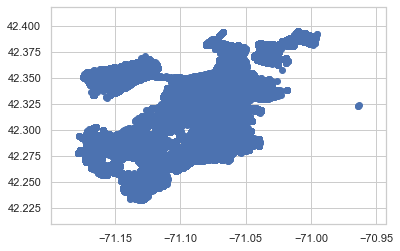

In [141]:
plt.scatter(X_train['Long'], X_train['Lat'])

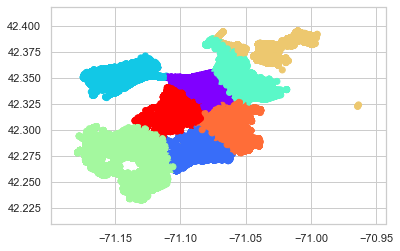

In [142]:
# separate by neigborhood
plt.scatter(X_train['Long'], X_train['Lat'], c=km.labels_, cmap='rainbow')

In [110]:
def calc_meanstd(X_train, y_train, X_test, y_test, clusters):

    # store output variables
    cvmeans      = []
    cvstds       = []
    train_scores = []
    test_scores  = []
    
    # test different clusters
    for clust in clusters:
        
        print("Cluster " + str(clust) + "...")
        
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        
        km_train = KMeans(n_clusters = clust).fit(X_train[['Long', 'Lat']])
        
        dummies = pd.get_dummies(km_train.predict(X_train[['Long', 'Lat']]), prefix="cluster")
        dummies.index = X_train_copy.index
        X_train_copy = X_train_copy.join(dummies)
        
        km_test = KMeans(n_clusters = clust).fit(X_test[['Long', 'Lat']])
        
        dummies = pd.get_dummies(km_test.predict(X_test[['Long', 'Lat']]), prefix="cluster")
        dummies.index = X_test_copy.index
        X_test_copy = X_test_copy.join(dummies)
        
        print("Dummies Done")
        
        # create model
#         model = LogisticRegressionCV(Cs=100000, cv=5, random_state=42)
#         model = LogisticRegressionCV(cv=5, random_state=42)
        model = RandomForestClassifier()
        
#         # use k=5 cross validation to evaluate performance
#         cv_scores = cross_val_score(model, X_train_copy, y_train, cv=5)
        
#         # store mean and std of cv scores
#         cvmeans.append(np.mean(cv_scores))
#         cvstds.append(np.std(cv_scores))
    
        # evaluate performance on training set
        model.fit(X_train_copy, y_train)
        print("Fit Done")
        y_pred_train = model.predict(X_train_copy)
        y_pred_test = model.predict(X_test_copy)
        acc_score_train = accuracy_score(y_pred_train, y_train)
        acc_score_test = accuracy_score(y_pred_test, y_test)
        train_scores.append(acc_score_train)
        test_scores.append(acc_score_test)
        
        print("Scores Done")
    
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores

In [111]:
clusters = list(range(8,20))
cvmeans, cvstds, train_scores, test_scores = calc_meanstd(X_train, y_train, X_test, y_test, clusters)

Cluster 8...
Dummies Done
Fit Done
Scores Done
Cluster 9...
Dummies Done
Fit Done
Scores Done
Cluster 10...
Dummies Done
Fit Done
Scores Done
Cluster 11...
Dummies Done
Fit Done
Scores Done
Cluster 12...
Dummies Done
Fit Done
Scores Done
Cluster 13...
Dummies Done
Fit Done
Scores Done
Cluster 14...
Dummies Done
Fit Done
Scores Done
Cluster 15...
Dummies Done
Fit Done
Scores Done
Cluster 16...
Dummies Done
Fit Done
Scores Done
Cluster 17...
Dummies Done
Fit Done
Scores Done
Cluster 18...
Dummies Done
Fit Done
Scores Done
Cluster 19...
Dummies Done
Fit Done
Scores Done


In [112]:
test_scores

[0.4532517504573267,
 0.4595975525137198,
 0.4512962846148994,
 0.4504888664606068,
 0.4486847915221094,
 0.45299943228411027,
 0.4499968460228348,
 0.4486595597047877,
 0.4489497256039866,
 0.44873525515675267,
 0.4526461868416073,
 0.45040055509998106]

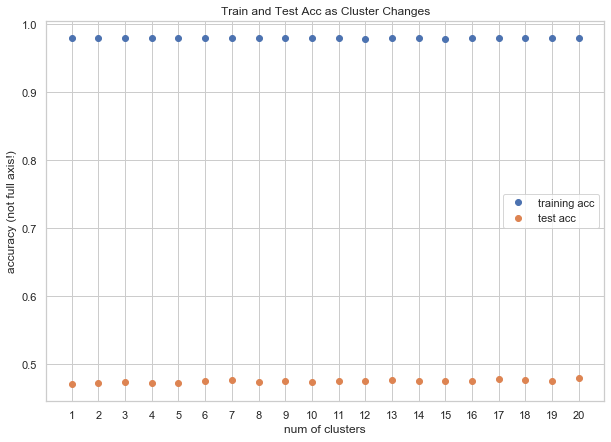

In [85]:
# initialize figure
fig = plt.figure(figsize=(10,7))

# # get data for mean +/- 2std 
# stdabove = np.array(cvmeans) + 2*np.array(cvstds)
# stdbelow = np.array(cvmeans) - 2*np.array(cvstds)

# # plot cvmeans and cvstds
# plt.plot(cvmeans,'k',label='test acc')
# plt.plot(stdabove,'orange')
# plt.plot(stdbelow,'orange')

# # fill in between space
# plt.fill_between(range(len(cvmeans)),stdbelow,stdabove,color='orange',alpha=.3,label='2std')

# plot training scores
plt.plot(train_scores,'o',label='training acc')
plt.plot(test_scores,'o',label='test acc')

# plot formatting
# plt.title('cv scores with std')
plt.title('Train and Test Acc as Cluster Changes')
plt.xlabel('num of clusters')
# plt.ylim(0.54,0.7) # can set the y-axis to focus on the cross-validation performance
plt.xticks(range(0,20),range(1,21))
plt.ylabel('accuracy (not full axis!)')
plt.legend()
plt.show()

In [106]:
def calc_meanstd(X_train, y_train, X_test, y_test, clusters):

    fig = plt.figure(figsize=(10,7))
    
    # store output variables
    cvmeans      = []
    cvstds       = []
    train_scores = []
    test_scores  = []
    
    # test different clusters
    for clust in clusters:
        
        print("Cluster " + str(clust) + "...")
        
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        
        km_train = KMeans(n_clusters = clust).fit(X_train[['Long', 'Lat']])
        
        dummies = pd.get_dummies(km_train.predict(X_train[['Long', 'Lat']]), prefix="cluster")
        dummies.index = X_train_copy.index
        X_train_copy = X_train_copy.join(dummies)
        
        km_test = KMeans(n_clusters = clust).fit(X_test[['Long', 'Lat']])
        
        dummies = pd.get_dummies(km_test.predict(X_test[['Long', 'Lat']]), prefix="cluster")
        dummies.index = X_test_copy.index
        X_test_copy = X_test_copy.join(dummies)
        
        plt.subplot(len(clusters), 1, clust - clusters[0] + 1)
        
        plt.scatter(X_test['Long'], X_test['Lat'], c=km.labels_, cmap='rainbow')
        
        print("Dummies Done")
        
        # create model
#         model = LogisticRegressionCV(Cs=100000, cv=5, random_state=42)
#         model = LogisticRegressionCV(cv=5, random_state=42)
        model = RandomForestClassifier()
        
#         # use k=5 cross validation to evaluate performance
#         cv_scores = cross_val_score(model, X_train_copy, y_train, cv=5)
        
#         # store mean and std of cv scores
#         cvmeans.append(np.mean(cv_scores))
#         cvstds.append(np.std(cv_scores))
    
        # evaluate performance on training set
        model.fit(X_train_copy, y_train)
        print("Fit Done")
        y_pred_train = model.predict(X_train_copy)
        y_pred_test = model.predict(X_test_copy)
        acc_score_train = accuracy_score(y_pred_train, y_train)
        acc_score_test = accuracy_score(y_pred_test, y_test)
        train_scores.append(acc_score_train)
        test_scores.append(acc_score_test)
        
        print("Scores Done")
    
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores

Cluster 8...
Dummies Done
Fit Done
Scores Done


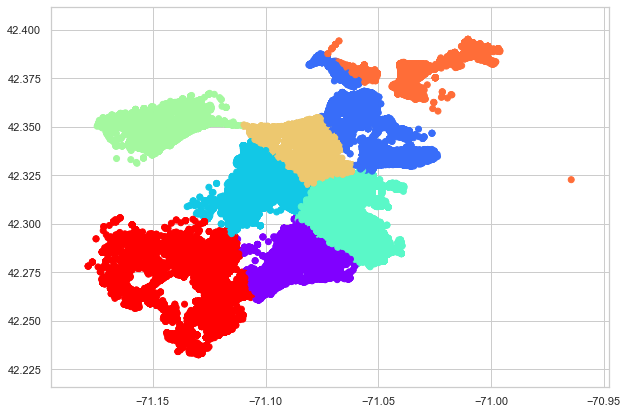

In [107]:
clusters = list(range(8,9))
cvmeans, cvstds, train_scores, test_scores = calc_meanstd(X_train, y_train, X_test, y_test, clusters)

In [131]:
def ucr_to_num(x):
    if x == 'Part One':
        return 1
    elif x == 'Part Two':
        return 2
    else:
        return 3

y_train_num = y_train.apply(ucr_to_num)
y_train_num

32244     3
217552    3
238273    2
31886     2
298686    3
249927    3
107641    3
157877    2
114968    2
2326      2
170472    2
189571    3
140766    3
163084    3
173560    1
124134    2
198219    2
56473     2
273046    3
155251    2
363138    2
22690     2
347826    3
279093    1
56850     2
103846    3
369668    3
59564     2
223627    2
126210    2
         ..
185085    1
214536    2
236201    1
103524    2
267911    3
199373    3
253138    1
327658    2
194350    3
322454    3
263359    3
64925     3
329960    3
41154     1
278643    2
191654    2
175493    2
389207    2
375594    3
87646     3
137567    3
54977     3
208238    2
110447    2
120075    1
259617    3
366546    2
132155    1
147115    2
122157    2
Name: UCR_PART, Length: 317057, dtype: int64

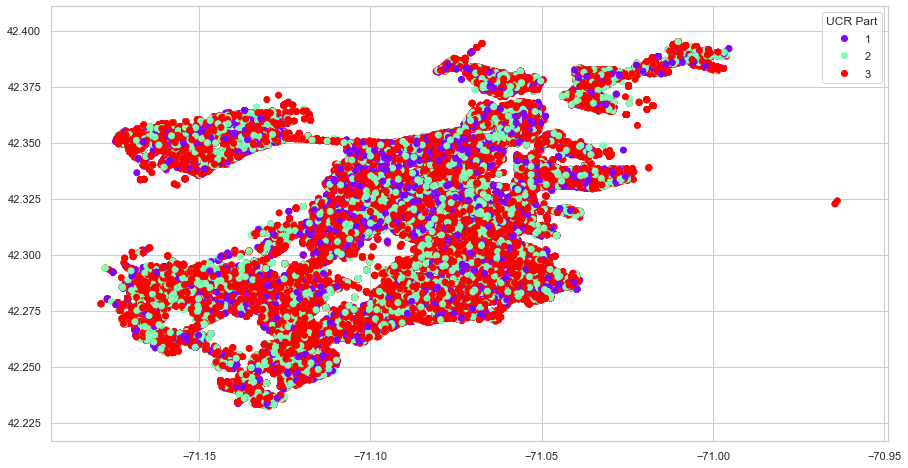

In [132]:
# plt.figure(figsize=(15,8))
# plt.scatter(X_train['Long'], X_train['Lat'], c=y_train_num, cmap='rainbow')
# plt.legend()

fig, ax = plt.subplots(figsize=(15,8))

scatter = ax.scatter(X_train['Long'], X_train['Lat'], c=y_train_num, cmap='rainbow')

legend = ax.legend(*scatter.legend_elements(), title='UCR Part')